In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [ ]:
data = pd.read_csv('train.csv')
data.head()

,row_id,datetime,energy
0,1,2008-03-01 00:00:00,1259.985563
1,2,2008-03-01 01:00:00,1095.541500
2,3,2008-03-01 02:00:00,1056.247500
3,4,2008-03-01 03:00:00,1034.742000
4,5,2008-03-01 04:00:00,1026.334500


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94992 entries, 0 to 94991
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   row_id    94992 non-null  int64  
 1   datetime  94992 non-null  object 
 2   energy    93092 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ MB


In [ ]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [ ]:
data.drop(columns=['row_id'],inplace=True)
data.set_index('datetime',inplace=True)
data.head()

,energy
datetime,
2008-03-01 00:00:00,1259.985563
2008-03-01 01:00:00,1095.541500
2008-03-01 02:00:00,1056.247500
2008-03-01 03:00:00,1034.742000
2008-03-01 04:00:00,1026.334500


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 94992 entries, 2008-03-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   energy  93092 non-null  float64
dtypes: float64(1)
memory usage: 1.4 MB


In [ ]:
data.describe()

,energy
count,93092.000000
mean,1702.995014
std,369.322103
min,866.388600
25%,1431.541100
50%,1654.465800
75%,1935.993450
max,3374.399600


In [ ]:
data.isnull().sum()

energy    1900
dtype: int64

In [ ]:
data.fillna(method='ffill',inplace=True)
data.isnull().sum()

energy    0
dtype: int64

In [ ]:
data.describe()

,energy
count,94992.000000
mean,1703.149845
std,369.301283
min,866.388600
25%,1431.662400
50%,1654.646150
75%,1936.203000
max,3374.399600


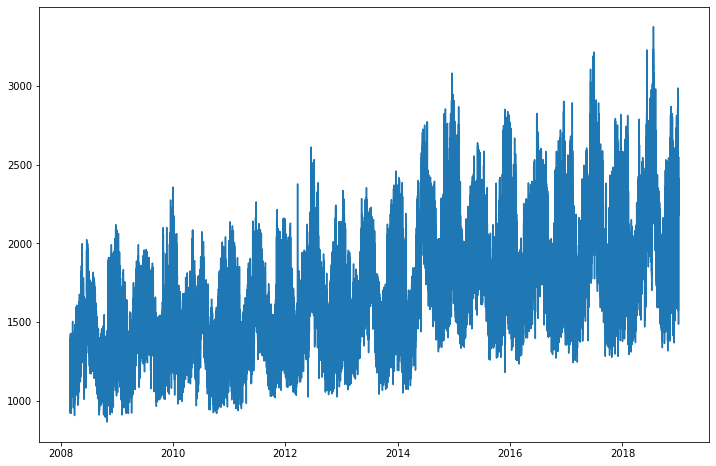

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(data.energy)

In [ ]:
#!pip install pmdarima

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
result  = seasonal_decompose(data)


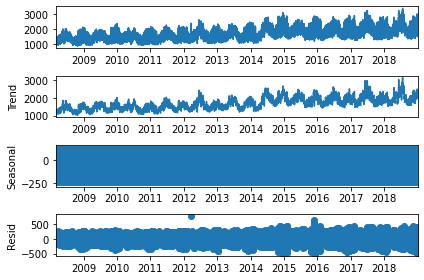

<Figure size 1080x576 with 0 Axes>

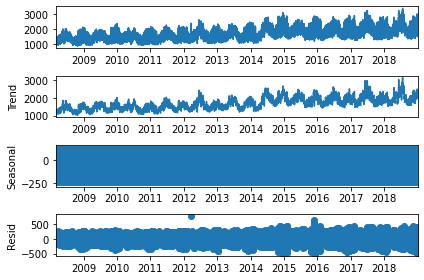

In [ ]:
plt.figure(figsize=(15,8))
result.plot()

In [ ]:
#checking for stationarity of data using ADF test
from statsmodels.tsa.stattools import adfuller

#creating function for ADFuller test

def adf_test(data):
  adftest = adfuller(data, autolag = 'AIC')
  print("1. ADF:", adftest[0])
  print('2. p-value:',adftest[1])
  print('3. Num of lags:',adftest[2])
  print('4. num of observations used for regression and critical value calcualtion:',adftest[3])
  print('5. Critical values:')
  for key,val in adftest[4].items():
    print("\t",key, ": ",val)
  
  if adftest[1] < 0.05:
    print('data is stationary')
  else:
    print('data is not stationary')

adf_test(data.energy)


1. ADF: -9.21857073944749
2. p-value: 1.80572427906228e-15
3. Num of lags: 67
4. num of observations used for regression and critical value calcualtion: 94924
5. Critical values:
	 1% :  -3.4304188917117377
	 5% :  -2.8615704490393217
	 10% :  -2.5667862069612752
data is stationary


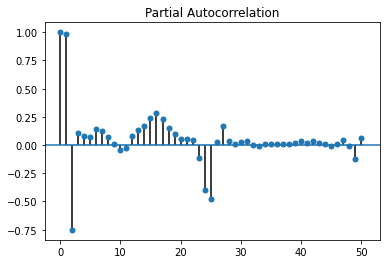

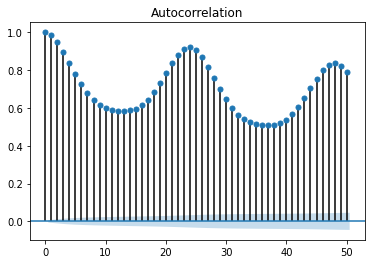

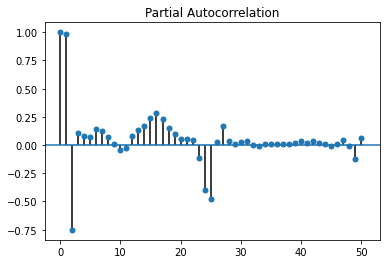

In [ ]:
#looks like data is stationary
# plotting ACF and PACF curves to find best fit model

from statsmodels.graphics.tsaplots import plot_acf , plot_pacf

plot_acf(data,alpha=0.05)
plot_pacf(data,alpha=0.05)


In [ ]:
##looks like ACF is not converging
# we will try to do one difference and check for ACF again

#transforming using boxcox 
#from scipy.stats import boxcox
#energy_boxcox = boxcox(data.energy)

from sklearn.preprocessing import power_transform

data['energy_box_cox'] = power_transform(data,method = 'box-cox')
data.head()


,energy,energy_box_cox
datetime,,
2008-03-01 00:00:00,1259.985563,-1.302316
2008-03-01 01:00:00,1095.541500,-1.970358
2008-03-01 02:00:00,1056.247500,-2.145931
2008-03-01 03:00:00,1034.742000,-2.245008
2008-03-01 04:00:00,1026.334500,-2.284343


In [ ]:
adf_test(data['energy_box_cox'])

1. ADF: -9.2533291363354
2. p-value: 1.472093725192214e-15
3. Num of lags: 67
4. num of observations used for regression and critical value calcualtion: 94924
5. Critical values:
	 1% :  -3.4304188917117377
	 5% :  -2.8615704490393217
	 10% :  -2.5667862069612752
data is stationary


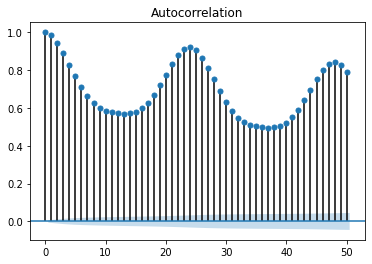

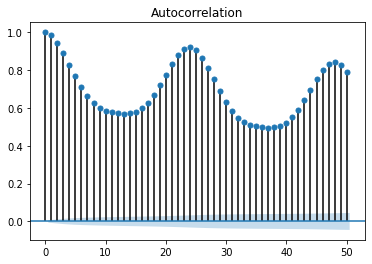

In [ ]:
plot_acf(data['energy_box_cox'])

In [ ]:
#calculating rolling mean
roll_mean = data['energy'].rolling(window=24).mean()
roll_mean

datetime
2008-03-01 00:00:00            NaN
2008-03-01 01:00:00            NaN
2008-03-01 02:00:00            NaN
2008-03-01 03:00:00            NaN
2008-03-01 04:00:00            NaN
                          ...     
2018-12-31 19:00:00    1970.945900
2018-12-31 20:00:00    1978.277400
2018-12-31 21:00:00    1985.989683
2018-12-31 22:00:00    1994.668133
2018-12-31 23:00:00    2002.238333
Name: energy, Length: 94992, dtype: float64

In [ ]:
data['energy_diff1'] = data.energy - roll_mean
data.head()

,energy,energy_box_cox,energy_diff1
datetime,,,
2008-03-01 00:00:00,1259.985563,-1.302316,NaN
2008-03-01 01:00:00,1095.541500,-1.970358,NaN
2008-03-01 02:00:00,1056.247500,-2.145931,NaN
2008-03-01 03:00:00,1034.742000,-2.245008,NaN
2008-03-01 04:00:00,1026.334500,-2.284343,NaN


In [ ]:
data.dropna(inplace = True)
data.head()

,energy,energy_box_cox,energy_diff1
datetime,,,
2008-03-01 23:00:00,1244.9295,-1.359479,-19.075898
2008-03-02 00:00:00,1163.5095,-1.682020,-96.476063
2008-03-02 01:00:00,1085.0100,-2.016745,-174.536750
2008-03-02 02:00:00,1032.9720,-2.253261,-225.604938
2008-03-02 03:00:00,1004.6520,-2.387400,-252.671187


1. ADF: -39.49719505031099
2. p-value: 0.0
3. Num of lags: 67
4. num of observations used for regression and critical value calcualtion: 94901
5. Critical values:
	 1% :  -3.430418908408635
	 5% :  -2.8615704564189985
	 10% :  -2.5667862108892345
data is stationary


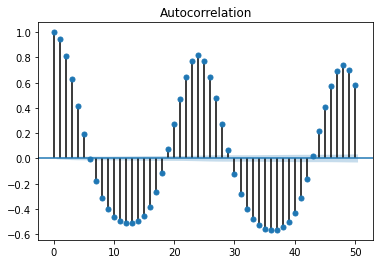

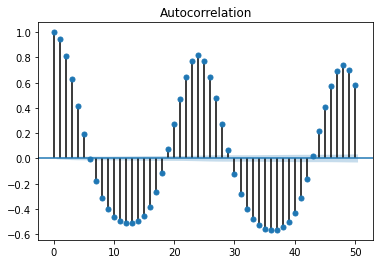

In [ ]:
adf_test(data['energy_diff1'])
plot_acf(data['energy_diff1'])

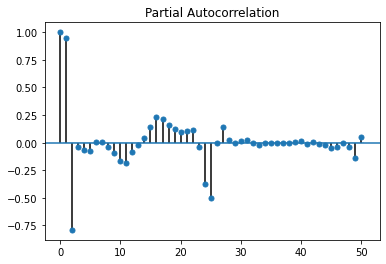

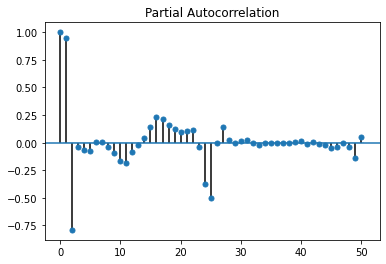

In [ ]:
plot_pacf(data['energy_diff1'])

In [ ]:
from numpy.core.numeric import roll
#calculation second differenceing

roll_mean1 = data['energy_diff1'].rolling(window=24).mean()
data['energy_diff2'] = data['energy_diff1'] - roll_mean1

data.dropna(inplace=True)
data.head()

,energy,energy_box_cox,energy_diff1,energy_diff2
datetime,,,,
2008-03-02 22:00:00,1240.3275,-1.377100,85.682750,148.458616
2008-03-02 23:00:00,1145.1900,-1.757924,-5.298938,56.902888
2008-03-03 00:00:00,1077.2220,-2.051359,-69.671625,-8.586651
2008-03-03 01:00:00,1012.7055,-2.348846,-131.175437,-71.897185
2008-03-03 02:00:00,956.4195,-2.625457,-184.271750,-126.715714


1. ADF: -51.51771202325775
2. p-value: 0.0
3. Num of lags: 67
4. num of observations used for regression and critical value calcualtion: 94878
5. Critical values:
	 1% :  -3.4304189251136274
	 5% :  -2.8615704638022534
	 10% :  -2.5667862148190985
data is stationary


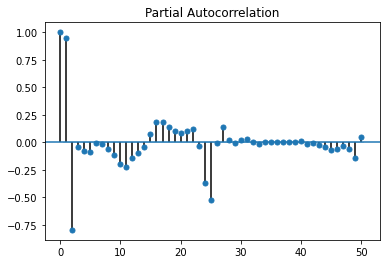

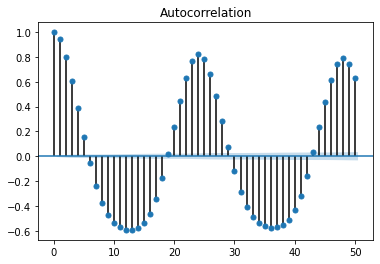

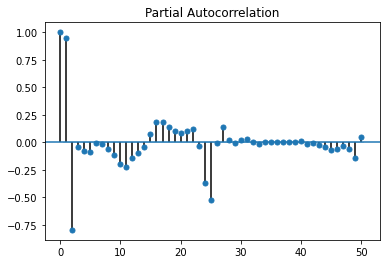

In [ ]:
adf_test(data['energy_diff2'])
plot_acf(data['energy_diff2'],alpha=0.05)
plot_pacf(data['energy_diff2'],alpha=0.05)

In [ ]:
##we can consider ARIMA model of order (5,1,3) , let us confirm with auto arima
#!pip install pmdarima
#from pmdarima import auto_arima


In [ ]:
#stepwise_fit = auto_arima(data['energy'],trace=True)
#stepwise_fit.summary()

#this gave best model as (3,1,3)

In [ ]:
#developing ARIMA model with order (3,1,3)
import statsmodels as sm1



In [ ]:
# splitting data into train and validation set

df = data['energy']
train = df.iloc[:75976]



In [ ]:
train

datetime
2008-03-02 22:00:00    1240.3275
2008-03-02 23:00:00    1145.1900
2008-03-03 00:00:00    1077.2220
2008-03-03 01:00:00    1012.7055
2008-03-03 02:00:00     956.4195
                         ...    
2016-11-01 09:00:00    1834.3395
2016-11-01 10:00:00    1906.4187
2016-11-01 11:00:00    1949.4378
2016-11-01 12:00:00    1978.7517
2016-11-01 13:00:00    2006.7966
Name: energy, Length: 75976, dtype: float64

In [ ]:
test = df.iloc[75976:]
test

datetime
2016-11-01 14:00:00    2027.6082
2016-11-01 15:00:00    2016.5679
2016-11-01 16:00:00    2021.1363
2016-11-01 17:00:00    2022.6591
2016-11-01 18:00:00    2027.9889
                         ...    
2018-12-31 19:00:00    2528.4468
2018-12-31 20:00:00    2461.8836
2018-12-31 21:00:00    2365.9944
2018-12-31 22:00:00    2342.9428
2018-12-31 23:00:00    2180.2176
Name: energy, Length: 18970, dtype: float64

In [ ]:
model1 = sm1.tsa.arima.model.ARIMA(endog = train, order=(3, 1, 3))
results = model1.fit()

AttributeError: ignored

In [ ]:
pred = results.predict()

In [ ]:
start = len(train)

end = len(train)+len(test)-1

pred = results.predict(start =start , end =end)



In [ ]:
pred

2016-10-31 15:00:00    1846.783289
2016-10-31 16:00:00    1872.820032
2016-10-31 17:00:00    1894.519247
2016-10-31 18:00:00    1906.064777
2016-10-31 19:00:00    1904.693961
                          ...     
2018-12-31 19:00:00    1676.412627
2018-12-31 20:00:00    1676.412627
2018-12-31 21:00:00    1676.412627
2018-12-31 22:00:00    1676.412627
2018-12-31 23:00:00    1676.412627
Freq: H, Name: predicted_mean, Length: 18993, dtype: float64

In [ ]:
pred.mean()

1676.4664474914348

In [ ]:
pred_df = pd.DataFrame(pred)
pred_df.head()

,predicted_mean
2016-10-31 15:00:00,1846.783289
2016-10-31 16:00:00,1872.820032
2016-10-31 17:00:00,1894.519247
2016-10-31 18:00:00,1906.064777
2016-10-31 19:00:00,1904.693961


In [ ]:
pred[190:210]

2016-11-08 13:00:00    1676.257930
2016-11-08 14:00:00    1676.716659
2016-11-08 15:00:00    1677.131858
2016-11-08 16:00:00    1677.477984
2016-11-08 17:00:00    1677.735399
2016-11-08 18:00:00    1677.891389
2016-11-08 19:00:00    1677.940660
2016-11-08 20:00:00    1677.885320
2016-11-08 21:00:00    1677.734360
2016-11-08 22:00:00    1677.502707
2016-11-08 23:00:00    1677.209925
2016-11-09 00:00:00    1676.878673
2016-11-09 01:00:00    1676.533035
2016-11-09 02:00:00    1676.196839
2016-11-09 03:00:00    1675.892075
2016-11-09 04:00:00    1675.637519
2016-11-09 05:00:00    1675.447643
2016-11-09 06:00:00    1675.331865
2016-11-09 07:00:00    1675.294171
2016-11-09 08:00:00    1675.333132
Freq: H, Name: predicted_mean, dtype: float64

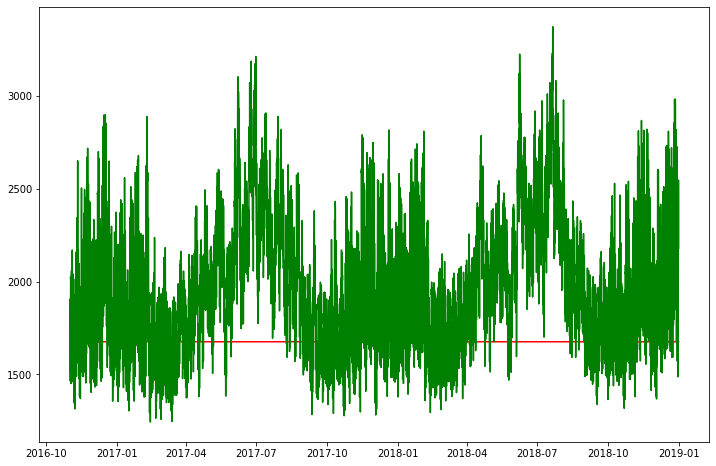

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(pred, label = 'predicted values',color='r')
plt.plot(test,label = 'test values',color='g')

In [ ]:
np.where(pred_df['predicted_mean']==1676.412627)

(array([], dtype=int64),)

In [ ]:
pred_df.loc[pred_df['predicted_mean']==1676.412627].value_counts()

Series([], dtype: int64)

In [ ]:
test

datetime
2016-10-31 15:00:00    1831.1670
2016-10-31 16:00:00    1837.3851
2016-10-31 17:00:00    1837.3851
2016-10-31 18:00:00    1852.7400
2016-10-31 19:00:00    1837.8927
                         ...    
2018-12-31 19:00:00    2528.4468
2018-12-31 20:00:00    2461.8836
2018-12-31 21:00:00    2365.9944
2018-12-31 22:00:00    2342.9428
2018-12-31 23:00:00    2180.2176
Name: energy, Length: 18993, dtype: float64

In [ ]:
pred.shape

(18993,)

In [ ]:
rmse = np.sqrt(mean_squared_error(test, pred))

In [ ]:
rmse

477.8705965601919